In [1]:
!pip3 install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 25.1.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import seaborn as sns
import glob
from scipy.spatial import ConvexHull
from scipy.optimize import linear_sum_assignment
from scipy.stats import multivariate_normal
from scipy.spatial import Delaunay
from sklearn.cluster import KMeans
import warnings
import json
import networkx as nx
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
from scipy.linalg import sqrtm
from scipy.optimize import linear_sum_assignment
from utils import *
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")


In [3]:
def wasserstein_distance_gaussian(mean1, cov1, mean2, cov2):
    # Compute the squared difference between the means.
    mean_diff_sq = np.linalg.norm(mean1 - mean2)**2

    # Compute the matrix square root of cov1
    cov1_sqrt = sqrtm(cov1)
    
    # Compute the product cov1_sqrt * cov2 * cov1_sqrt
    product = cov1_sqrt @ cov2 @ cov1_sqrt
    
    # Compute the square root of the product matrix
    sqrt_product = sqrtm(product)
    
    # Compute the trace term
    trace_term = np.trace(cov1 + cov2 - 2 * sqrt_product)
    
    # Return the 2-Wasserstein distance (ensure non-negative)
    return np.sqrt(max(mean_diff_sq + trace_term, 0))


In [4]:
def compute_emd(formation1, formation2):
    n = len(formation1)
    m = len(formation2)
    cost_matrix = np.zeros((n, m))
    
    for i in range(n):
        for j in range(m):
            mean1, cov1 = formation1[i]
            mean2, cov2 = formation2[j]
            cost_matrix[i, j] = wasserstein_distance_gaussian(mean1, cov1, mean2, cov2)
    
    
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    total_cost = cost_matrix[row_ind, col_ind].sum()
    
    return total_cost


In [5]:
# with open('tracks.json', 'r') as f:
#     tracks_z14 = json.load(f)

with open('tracks.json', 'r') as f:
    tracks_z14 = json.load(f)

with open('extern_adjusted_tracks_mirrored_5min_window.json', 'r') as f:
    tracks_extern = json.load(f)

with open('adjusted_tracks_mirroed_5-10min_window_2.json', 'r') as f:
    tracks_extern_2 = json.load(f)

In [6]:
# Merge the two JSON structures
combined_data = {**tracks_z14, **tracks_extern, **tracks_extern_2}

with open("merged.json", "w") as output_file:
    json.dump(combined_data, output_file, indent=4)

print("Merged JSON saved as 'merged.json'")


Merged JSON saved as 'merged.json'


In [7]:
formations = []  # List to store each team's formation as a list of players.
team_names = []  # To keep track of team IDs

for team, roles in combined_data.items():
    for role_key, players in roles.items():
        if not players:  # Skip if the role is an empty object
            continue
        formation = []
        for player, stats in players.items():
            mean = np.array(stats['mean'])          
            covariance = np.array(stats['covariance']) 
            formation.append((mean, covariance))
        formations.append(formation)
        team_names.append(f"{team}_{role_key}")

num_formations = len(formations)
print(f"Number of formations: {num_formations}")
distance_matrix = np.zeros((num_formations, num_formations))

for i in range(num_formations):
    for j in range(i + 1, num_formations):
        distance = compute_emd(formations[i], formations[j])
        distance_matrix[i, j] = distance
        distance_matrix[j, i] = distance  # distance is symmetric


Number of formations: 57


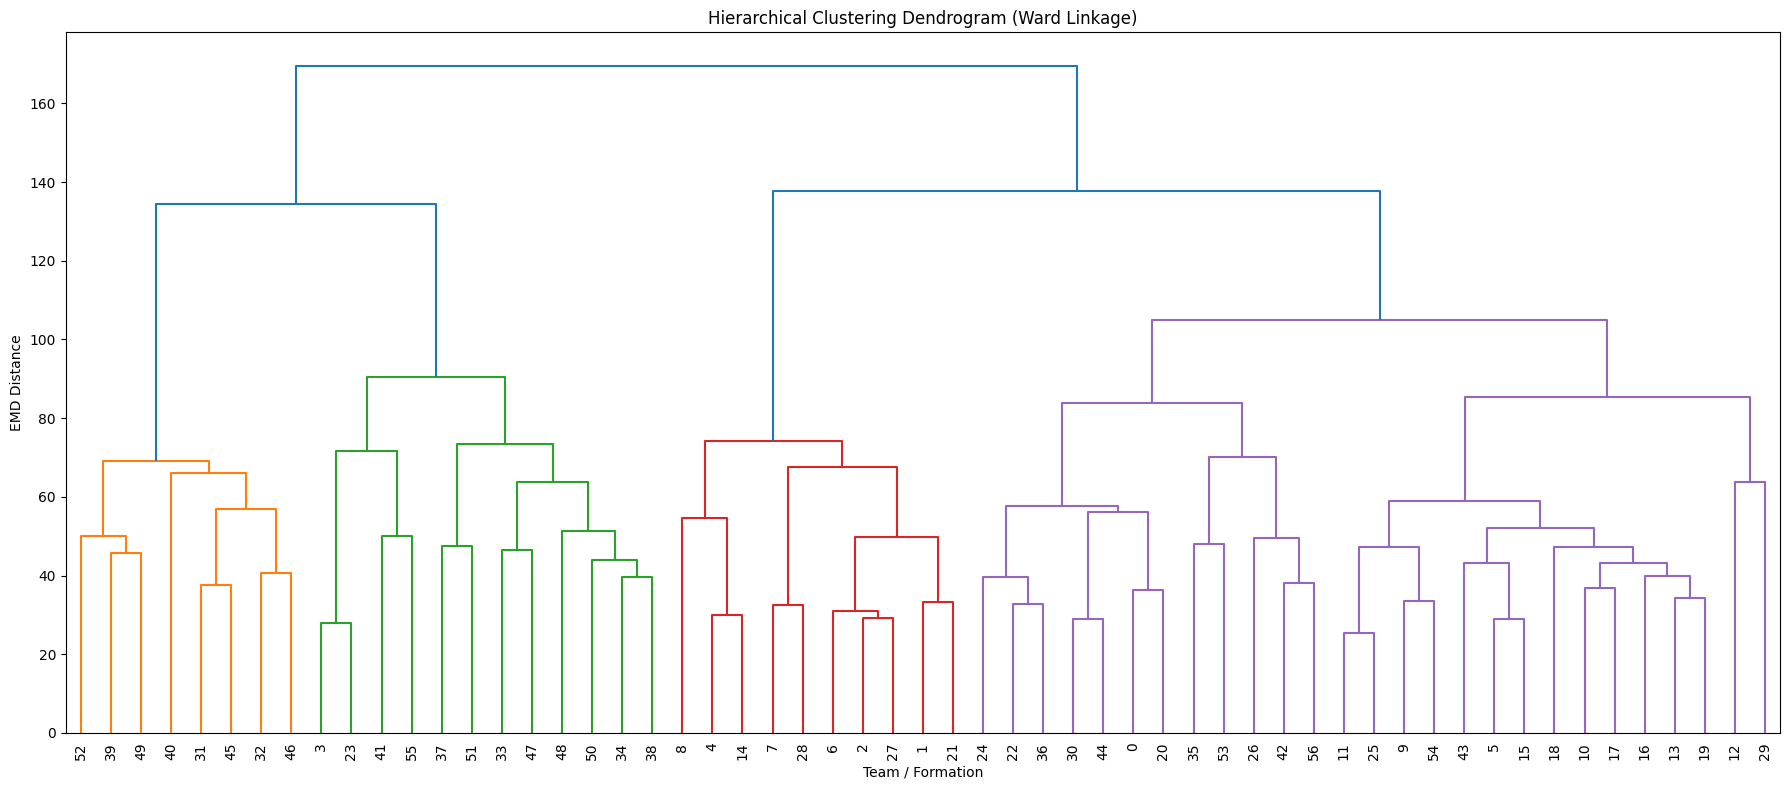

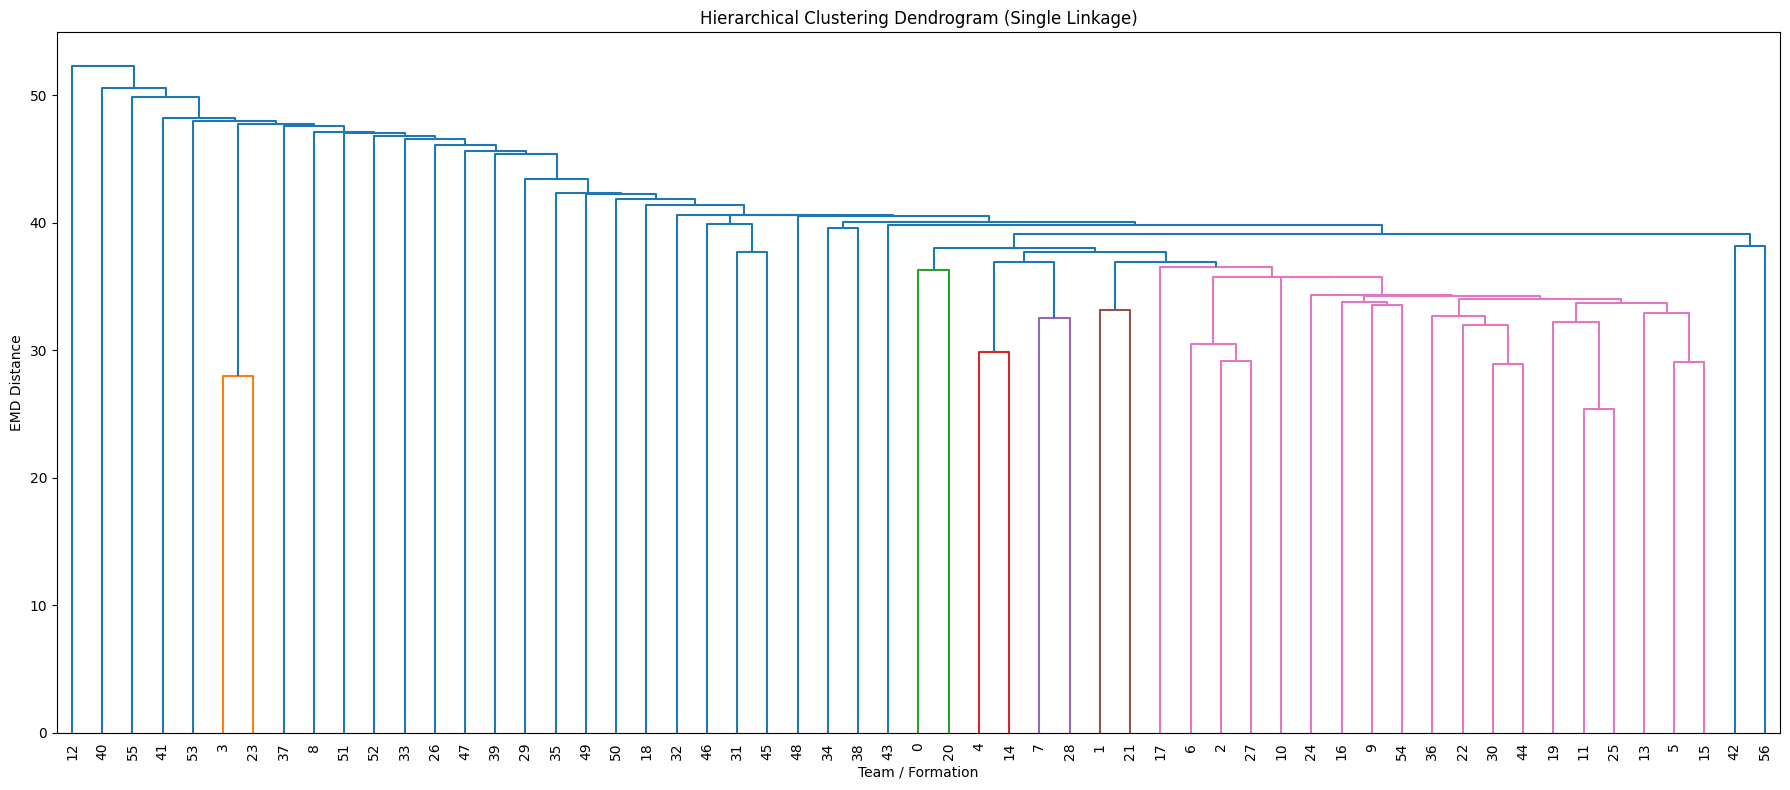

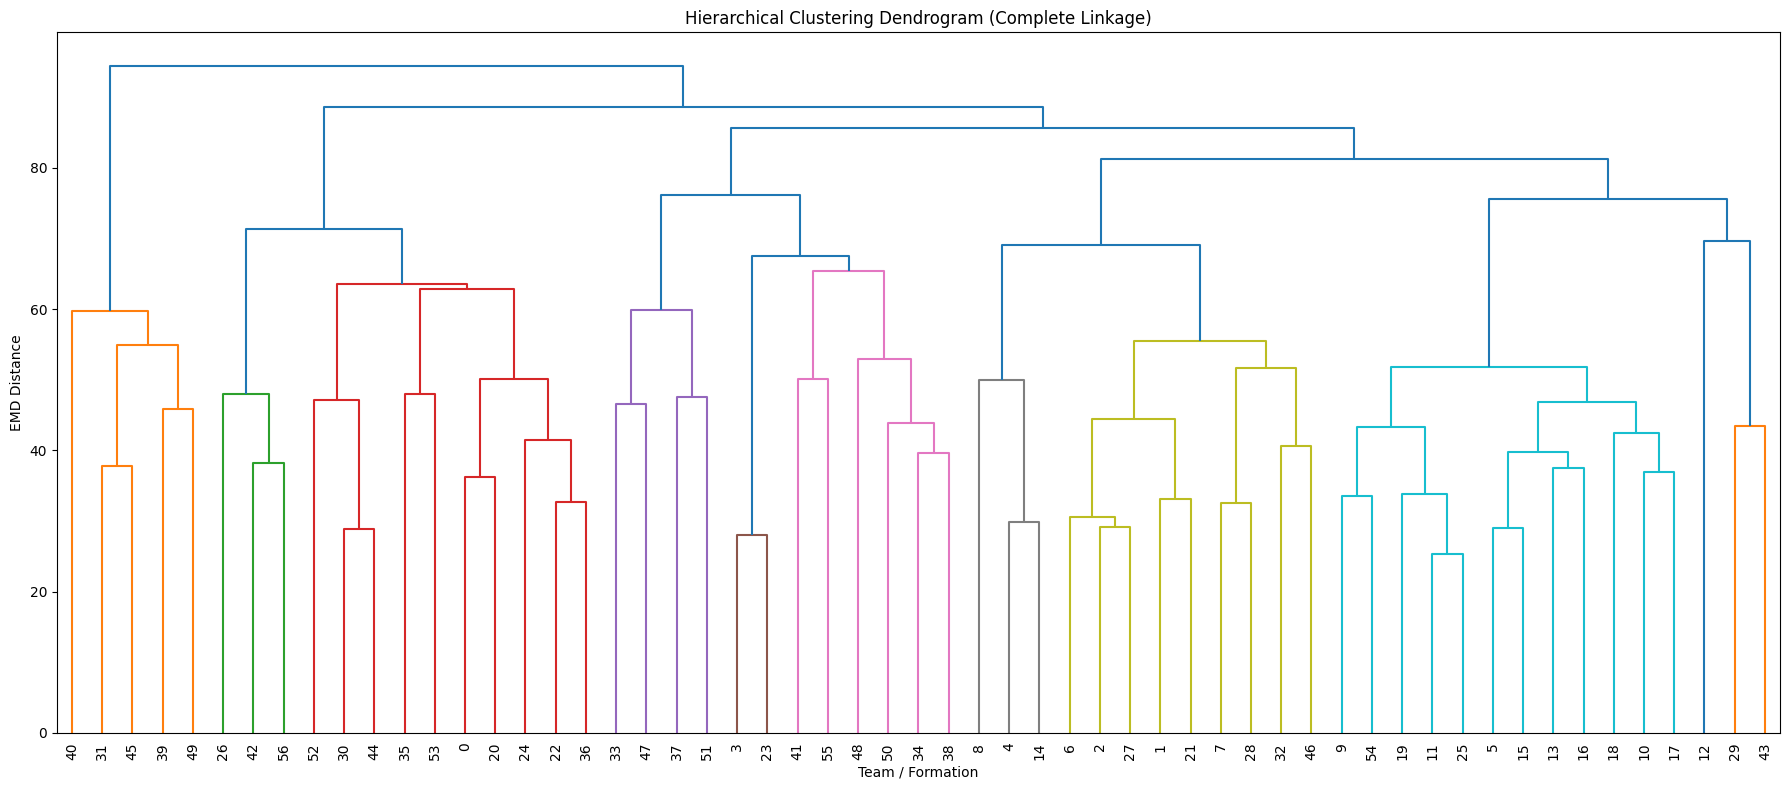

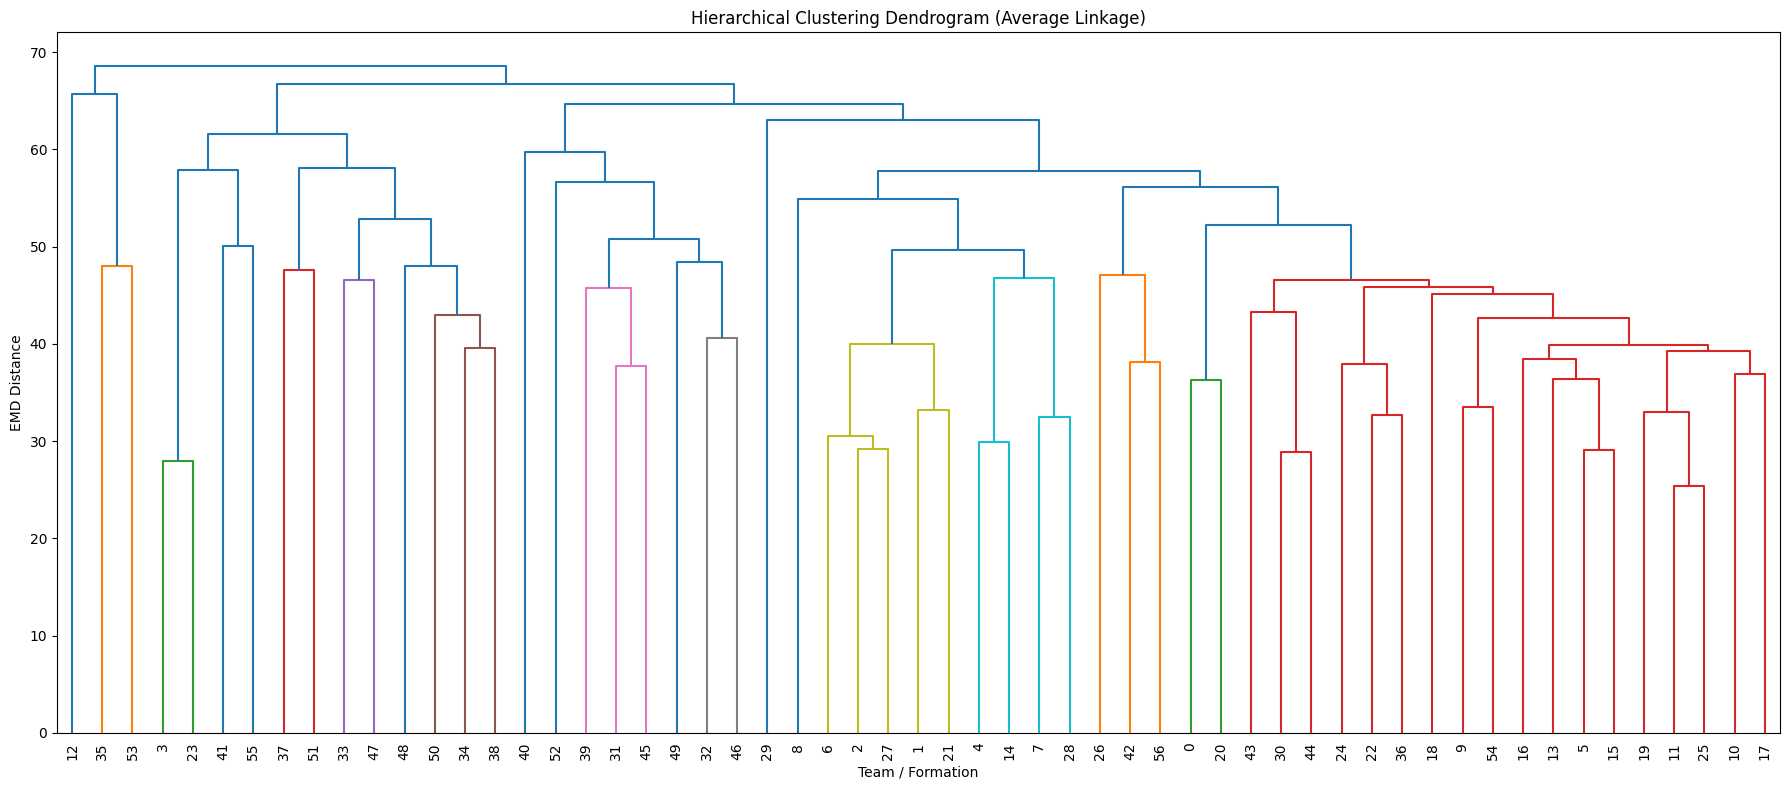

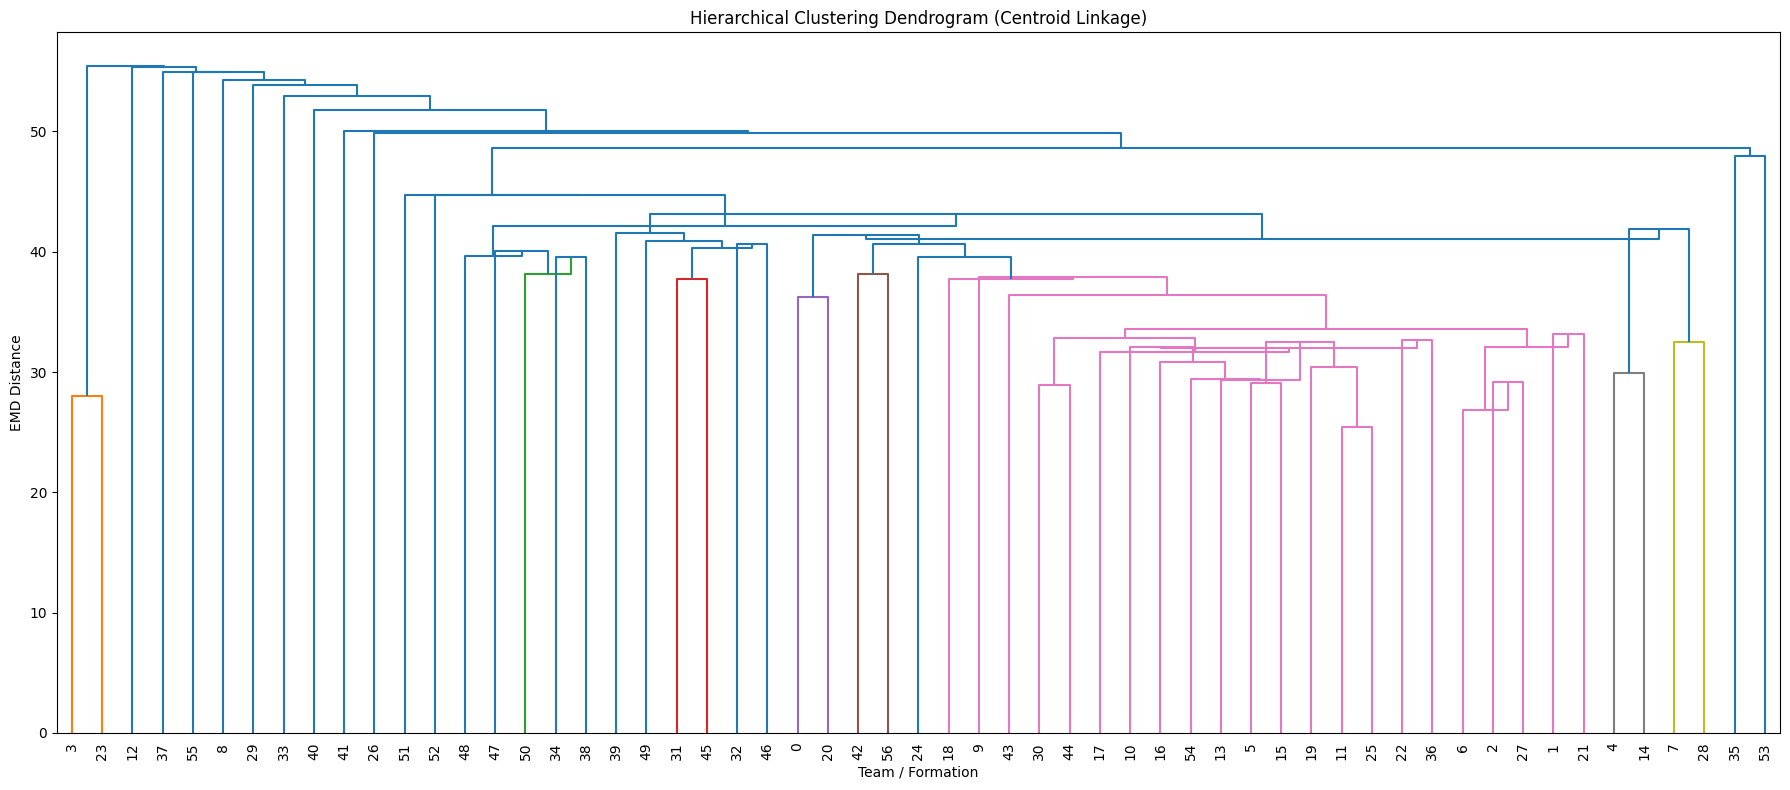

In [8]:

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
linkage_methods = ['ward', 'single', 'complete', 'average', 'centroid']
condensed_distance = squareform(distance_matrix)
linkage_matrix = linkage(condensed_distance, method='ward')

for method in linkage_methods:
    linkage_matrix = linkage(condensed_distance, method=method)
    
    plt.figure(figsize=(18, 8))
    dendrogram(linkage_matrix, leaf_rotation=90, leaf_font_size=10)
    plt.title(f'Hierarchical Clustering Dendrogram ({method.capitalize()} Linkage)')
    plt.xlabel('Team / Formation')
    plt.ylabel('EMD Distance')
    plt.tight_layout()
    plt.show()


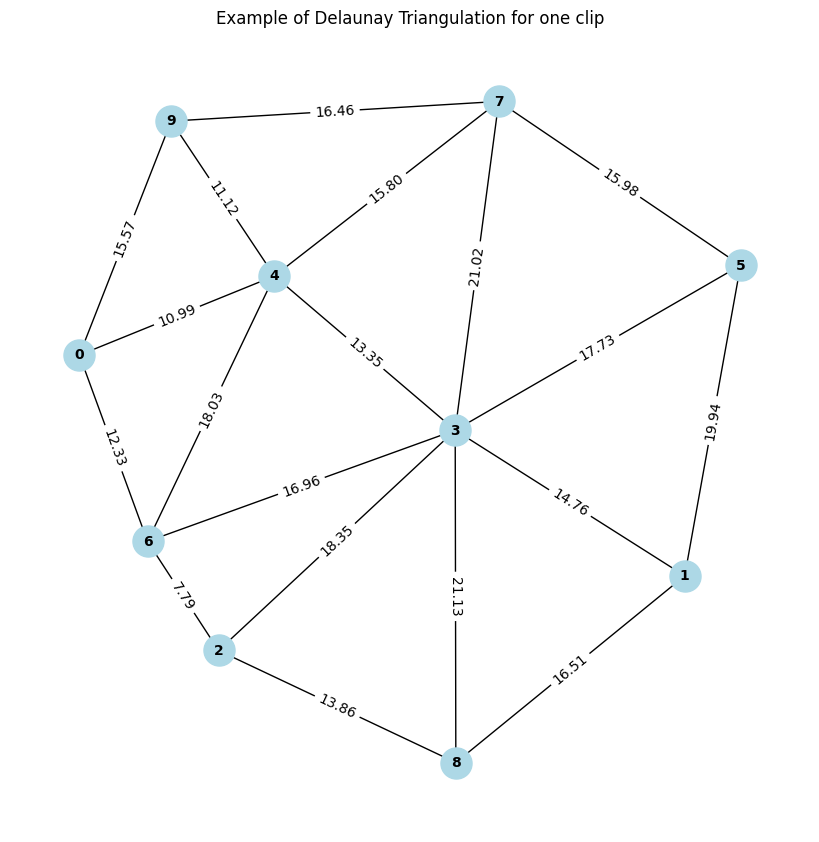

In [9]:
import numpy as np
import networkx as nx
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

# Loop through your dataset and generate adjacency matrices using Delaunay triangulation
all_adjacency_matrices = []

for clip_name, clip_data in combined_data.items():
    for role_key, players in clip_data.items():
        # Extract mean positions for roles
        role_means = np.array([players[str(i)]["mean"] for i in range(10) if str(i) in players])

        # Check if there are enough points for Delaunay triangulation
        if len(role_means) >= 3:
            # Perform Delaunay triangulation
            tri = Delaunay(role_means)

            # Initialize adjacency matrix
            adj_matrix = np.zeros((len(role_means), len(role_means)))

            # Populate adjacency matrix based on Delaunay simplices
            for simplex in tri.simplices:
                for i in range(len(simplex)):
                    for j in range(i + 1, len(simplex)):
                        distance = np.linalg.norm(role_means[simplex[i]] - role_means[simplex[j]])
                        adj_matrix[simplex[i], simplex[j]] = distance
                        adj_matrix[simplex[j], simplex[i]] = distance

            # Store adjacency matrix with identifiers
            all_adjacency_matrices.append({
                "clip": clip_name,
                "role": role_key,
                "adjacency_matrix": adj_matrix
            })

            # Create a graph from the adjacency matrix
            G = nx.from_numpy_array(adj_matrix)

            # Plot the graph
plt.figure(figsize=(8, 8))
pos = {i: role_means[i] for i in range(len(role_means))}
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold')
# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f'{d:.2f}' for u, v, d in G.edges(data='weight')})
plt.title(f'Example of Delaunay Triangulation for one clip')
plt.show()



In [10]:
import numpy as np
import networkx as nx
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
ground_truth = {  
    ("./xy_data/alt2_data.txt", "roles_0"): 4231,
    ("./xy_data/alt2_data.txt", "roles_1"): 442,

    ("./xy_data/alt_data.txt", "roles_0"): 4231,
    ("./xy_data/alt_data.txt", "roles_1"): 442,

    ("./xy_data/fis1_data.txt", "roles_0"): 442,
    ("./xy_data/fis1_data.txt", "roles_1"): 4231,

    ("./xy_data/fis2_data.txt", "roles_0"): 442,
    ("./xy_data/fis2_data.txt", "roles_1"): 4231,

    ("./xy_data/fried1_data.txt", "roles_1"): 442,

    ("./xy_data/friedr2_data.txt", "roles_0"): 442,
    ("./xy_data/friedr2_data.txt", "roles_1"): 442,

    ("./xy_data/gr1_data.txt", "roles_0"): 4231,
    ("./xy_data/gr1_data.txt", "roles_1"): 352,

    ("./xy_data/gr2_data.txt", "roles_0"): 4231,
    ("./xy_data/gr2_data.txt", "roles_1"): 352,

    ("./xy_data/m1_data.txt", "roles_0"): 442,
    ("./xy_data/m1_data.txt", "roles_1"): 442,

    ("./xy_data/m2_data.txt", "roles_0"): 442,
    ("./xy_data/m2_data.txt", "roles_1"): 442,

    ("./xy_data/st1_data.txt", "roles_0"): 4231,
    ("./xy_data/st1_data.txt", "roles_1"): 4231,

    ("./xy_data/st2_data.txt", "roles_0"): 4231,
    ("./xy_data/st2_data.txt", "roles_1"): 4231,

    ("./xy_data/stv1_data.txt", "roles_0"): 4231,

    ("./xy_data/stv2_data.txt", "roles_0"): 352,
    ("./xy_data/stv2_data.txt", "roles_1"): 442,

    # ("./xy_data/t1_data.txt", "roles_0"): 0,
    ("./xy_data/t1_data.txt", "roles_1"): 442,

    # ("./xy_data/t2_data.txt", "roles_0"): 0,
    ("./xy_data/t2_data.txt", "roles_0"): 442,

    
   
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WMX.xml', 'DFL-CLU-00000G'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WMX.xml', 'DFL-CLU-000008'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WN1.xml', 'DFL-CLU-00000B'): 4231,
    # ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WN1.xml', 'DFL-CLU-00000S'): 0, #here 4332
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WQQ.xml', 'DFL-CLU-00000P'): 352,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WQQ.xml', 'DFL-CLU-00000H'): 352,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WR9.xml', 'DFL-CLU-00000I'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WR9.xml', 'DFL-CLU-00000P'): 442, #here 4422
    # ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WPY.xml', 'DFL-CLU-000005'): 0, #here 4132
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WPY.xml', 'DFL-CLU-00000P'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOH.xml', 'DFL-CLU-00000P'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOH.xml', 'DFL-CLU-000011'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOY.xml', 'DFL-CLU-00000P'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOY.xml', 'DFL-CLU-00000Q'): 352,
    #-------------------------
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WMX_2.xml', 'DFL-CLU-00000G'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WMX_2.xml', 'DFL-CLU-000008'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WN1_2.xml', 'DFL-CLU-00000B'): 4231,
    # ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WN1_2.xml', 'DFL-CLU-00000S'): 0, # Changed 4231 to 4332 here
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WQQ_2.xml', 'DFL-CLU-00000P'): 352,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WQQ_2.xml', 'DFL-CLU-00000H'): 352,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WR9_2.xml', 'DFL-CLU-00000I'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WR9_2.xml', 'DFL-CLU-00000P'): 442, # Changed 442 to 4422 here
    # ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WPY_2.xml', 'DFL-CLU-000005'): 0, # Changed 442 to 4132 here
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WPY_2.xml', 'DFL-CLU-00000P'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOH_2.xml', 'DFL-CLU-00000P'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOH_2.xml', 'DFL-CLU-000011'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOY_2.xml', 'DFL-CLU-00000P'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOY_2.xml', 'DFL-CLU-00000Q'): 352
}

ground_truth_balanced = {  
    # ("./xy_data/alt2_data.txt", "roles_0"): 4231,
    ("./xy_data/alt2_data.txt", "roles_1"): 442,

    # ("./xy_data/alt_data.txt", "roles_0"): 4231,
    # ("./xy_data/alt_data.txt", "roles_1"): 442,

    # ("./xy_data/fis1_data.txt", "roles_0"): 442,
    # ("./xy_data/fis1_data.txt", "roles_1"): 4231,

    # ("./xy_data/fis2_data.txt", "roles_0"): 442,
    ("./xy_data/fis2_data.txt", "roles_1"): 4231,

    ("./xy_data/fried1_data.txt", "roles_1"): 442,

    # ("./xy_data/friedr2_data.txt", "roles_0"): 442,
    ("./xy_data/friedr2_data.txt", "roles_1"): 442,

    # ("./xy_data/gr1_data.txt", "roles_0"): 4231,
    ("./xy_data/gr1_data.txt", "roles_1"): 352,

    # ("./xy_data/gr2_data.txt", "roles_0"): 4231,
    ("./xy_data/gr2_data.txt", "roles_1"): 352,

    ("./xy_data/m1_data.txt", "roles_0"): 442,
    # ("./xy_data/m1_data.txt", "roles_1"): 442,

    # ("./xy_data/m2_data.txt", "roles_0"): 442,
    ("./xy_data/m2_data.txt", "roles_1"): 442,

    # ("./xy_data/st1_data.txt", "roles_0"): 4231,
    # ("./xy_data/st1_data.txt", "roles_1"): 4231,

    ("./xy_data/st2_data.txt", "roles_0"): 4231,
    ("./xy_data/st2_data.txt", "roles_1"): 4231,

    ("./xy_data/stv1_data.txt", "roles_0"): 4231,

    ("./xy_data/stv2_data.txt", "roles_0"): 352,
    ("./xy_data/stv2_data.txt", "roles_1"): 442,

    ("./xy_data/t1_data.txt", "roles_0"): 0,
    ("./xy_data/t1_data.txt", "roles_1"): 442,

    ("./xy_data/t2_data.txt", "roles_0"): 0,
    ("./xy_data/t2_data.txt", "roles_0"): 442,

    
   
    # ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WMX.xml', 'DFL-CLU-00000G'): 4231,
    # ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WMX.xml', 'DFL-CLU-000008'): 4231,
    # ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WN1.xml', 'DFL-CLU-00000B'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WN1.xml', 'DFL-CLU-00000S'): 0, #here 4332
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WQQ.xml', 'DFL-CLU-00000P'): 352,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WQQ.xml', 'DFL-CLU-00000H'): 352,
    # ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WR9.xml', 'DFL-CLU-00000I'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WR9.xml', 'DFL-CLU-00000P'): 442, #here 4422
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WPY.xml', 'DFL-CLU-000005'): 0, #here 4132
    # ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WPY.xml', 'DFL-CLU-00000P'): 4231,
    # ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOH.xml', 'DFL-CLU-00000P'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOH.xml', 'DFL-CLU-000011'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOY.xml', 'DFL-CLU-00000P'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOY.xml', 'DFL-CLU-00000Q'): 352,
    #-------------------------
    # ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WMX_2.xml', 'DFL-CLU-00000G'): 4231,
    # ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WMX_2.xml', 'DFL-CLU-000008'): 4231,
    # ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WN1_2.xml', 'DFL-CLU-00000B'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WN1_2.xml', 'DFL-CLU-00000S'): 0, # Changed 4231 to 4332 here
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WQQ_2.xml', 'DFL-CLU-00000P'): 352,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WQQ_2.xml', 'DFL-CLU-00000H'): 352,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WR9_2.xml', 'DFL-CLU-00000I'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WR9_2.xml', 'DFL-CLU-00000P'): 442, # Changed 442 to 4422 here
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WPY_2.xml', 'DFL-CLU-000005'): 0, # Changed 442 to 4132 here
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WPY_2.xml', 'DFL-CLU-00000P'): 4231,
    # ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOH_2.xml', 'DFL-CLU-00000P'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOH_2.xml', 'DFL-CLU-000011'): 4231,
    # ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOY_2.xml', 'DFL-CLU-00000P'): 4231,
    ('./data/DFL_04_03_positions_raw_observed_DFL-COM-000002_DFL-MAT-J03WOY_2.xml', 'DFL-CLU-00000Q'): 352
}






In [11]:
len(ground_truth)

52

In [ ]:
import numpy as np
import networkx as nx
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

def extract_features(adj):
    G = nx.from_numpy_array(adj)
    features = []

    degrees = [d for _, d in G.degree()]
    features.append(np.mean(degrees))
    features.append(np.std(degrees))

    clustering = list(nx.clustering(G).values())
    features.append(np.mean(clustering))
    features.append(np.std(clustering))

    features.append(nx.density(G))

    betweenness = list(nx.betweenness_centrality(G).values())
    features.append(np.mean(betweenness))
    features.append(np.std(betweenness))

    

    return np.array(features)


y = []
for entry in all_adjacency_matrices:
    clip = entry['clip']
    role = entry['role']
    if (clip, role) in ground_truth:
        y.append(ground_truth[(clip, role)])
    else:
        print(f"Warning: No ground truth label for ({clip}, {role}). Skipping...")
        y.append(None)




X_filtered = []
y_filtered = []
for i, label in enumerate(y):
    if label is not None:
      
        graph_features = extract_features(all_adjacency_matrices[i]['adjacency_matrix'])
        
        # Extract overall mean and covariance features
        clip_data = combined_data[all_adjacency_matrices[i]['clip']]
        role_data = clip_data[all_adjacency_matrices[i]['role']]
       
        combined_features = np.concatenate([graph_features])
        
        X_filtered.append(combined_features)
        y_filtered.append(label)

X = np.array(X_filtered)
y = np.array(y_filtered)



In [13]:
pd.DataFrame(X)

,0,1,2,3,4,5,6
0,3.8,1.166190,0.580000,0.110755,0.422222,0.091667,0.103910
1,4.0,1.000000,0.556667,0.094340,0.444444,0.086111,0.067728
2,4.0,1.000000,0.556667,0.094340,0.444444,0.086111,0.067728
3,4.0,1.000000,0.563333,0.108985,0.444444,0.086111,0.080397
4,4.0,1.095445,0.563333,0.108985,0.444444,0.083333,0.079191
5,4.0,1.000000,0.556667,0.094340,0.444444,0.086111,0.067728
6,4.0,1.000000,0.556667,0.094340,0.444444,0.086111,0.067728
7,4.0,1.000000,0.556667,0.094340,0.444444,0.086111,0.067728
8,3.8,1.166190,0.580000,0.110755,0.422222,0.091667,0.103910
9,3.8,1.166190,0.580000,0.110755,0.422222,0.091667,0.103910


In [14]:
# --- Train/Test split and model training (unchanged) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         352       0.00      0.00      0.00         2
         442       1.00      1.00      1.00         3
        4231       0.71      0.83      0.77         6

    accuracy                           0.73        11
   macro avg       0.57      0.61      0.59        11
weighted avg       0.66      0.73      0.69        11




🔍 Running GridSearchCV for RandomForest...



✅ RandomForest Results
Best Score (Mean CV Accuracy): 0.5849
Best Params: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Classification Report:
              precision    recall  f1-score   support

         352       0.47      0.78      0.58         9
         442       0.56      0.60      0.58        15
        4231       0.70      0.52      0.60        27

    accuracy                           0.59        51
   macro avg       0.58      0.63      0.59        51
weighted avg       0.62      0.59      0.59        51



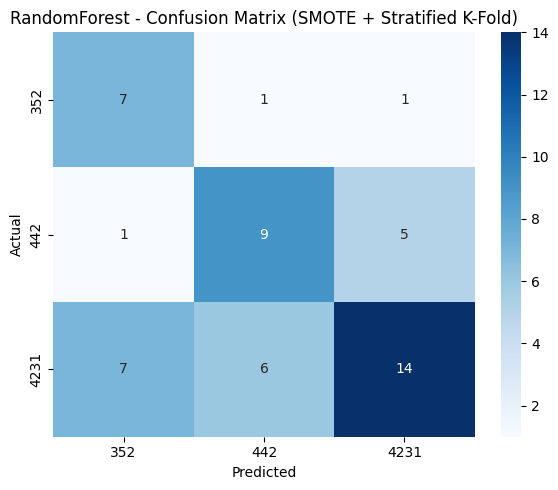


🔍 Running GridSearchCV for SVC...

✅ SVC Results
Best Score (Mean CV Accuracy): 0.6234
Best Params: {'clf__C': 1, 'clf__kernel': 'rbf'}
Classification Report:
              precision    recall  f1-score   support

         352       0.43      0.67      0.52         9
         442       0.65      0.73      0.69        15
        4231       0.75      0.56      0.64        27

    accuracy                           0.63        51
   macro avg       0.61      0.65      0.62        51
weighted avg       0.66      0.63      0.63        51



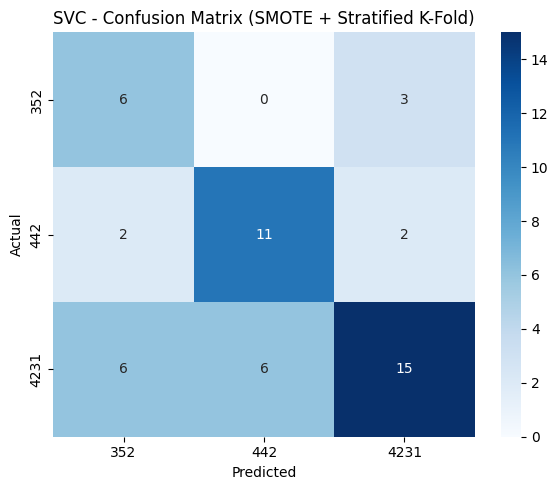


🔍 Running GridSearchCV for KNN...

✅ KNN Results
Best Score (Mean CV Accuracy): 0.7212
Best Params: {'clf__algorithm': 'auto', 'clf__leaf_size': 20, 'clf__n_neighbors': 3, 'clf__p': 2, 'clf__weights': 'uniform'}
Classification Report:
              precision    recall  f1-score   support

         352       0.70      0.78      0.74         9
         442       0.62      0.67      0.65        15
        4231       0.80      0.74      0.77        27

    accuracy                           0.73        51
   macro avg       0.71      0.73      0.72        51
weighted avg       0.73      0.73      0.73        51



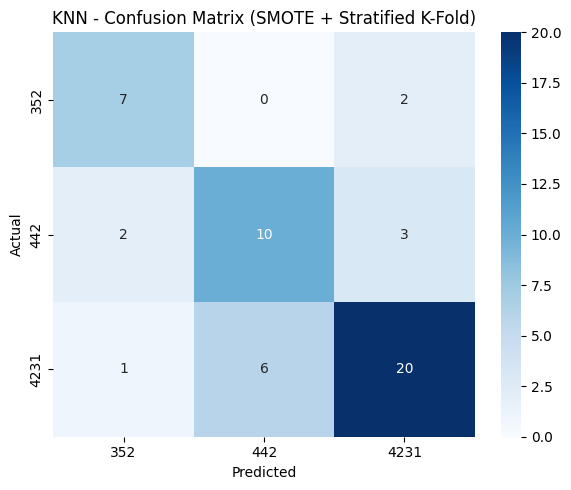


🔍 Running GridSearchCV for LogisticRegression...

✅ LogisticRegression Results
Best Score (Mean CV Accuracy): 0.6234
Best Params: {'clf__C': 0.1, 'clf__solver': 'liblinear'}
Classification Report:
              precision    recall  f1-score   support

         352       0.38      0.33      0.35         9
         442       0.63      0.80      0.71        15
        4231       0.71      0.63      0.67        27

    accuracy                           0.63        51
   macro avg       0.57      0.59      0.58        51
weighted avg       0.63      0.63      0.62        51



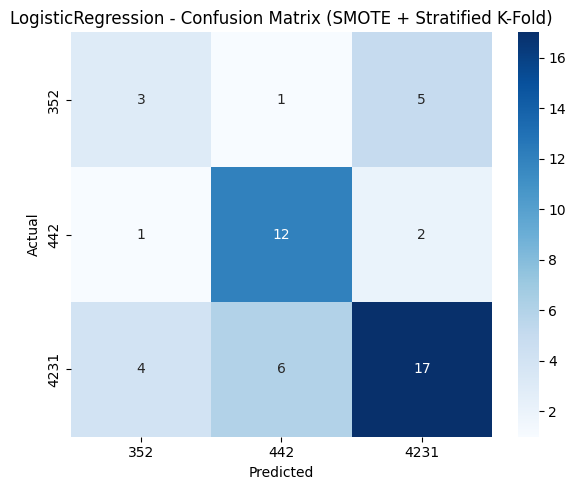


🔍 Running GridSearchCV for XGBoost...

✅ XGBoost Results
Best Score (Mean CV Accuracy): 0.6058
Best Params: {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'clf__subsample': 0.8}
Classification Report:
              precision    recall  f1-score   support

         352       0.46      0.67      0.55         9
         442       0.60      0.60      0.60        15
        4231       0.70      0.59      0.64        27

    accuracy                           0.61        51
   macro avg       0.59      0.62      0.60        51
weighted avg       0.63      0.61      0.61        51



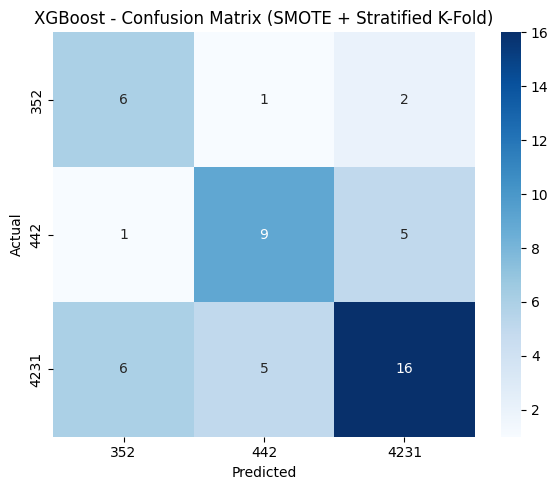

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='xgboost')
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=r".*use_label_encoder.*")
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib


cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)



joblib.dump(label_encoder, 'label_encoder.pkl')


models_and_parameters = {
    'RandomForest': {
        'pipeline': Pipeline([
            ('smote', SMOTE(k_neighbors=2, random_state=42)),
            ('clf', RandomForestClassifier(random_state=42))
        ]),
        'params': {
            'clf__n_estimators': [100],
            'clf__max_depth': [None, 10],
            'clf__min_samples_split': [2, 5]
        }
    },
    'SVC': {
        'pipeline': Pipeline([
            ('smote', SMOTE(k_neighbors=2, random_state=42)),
            ('scaler', StandardScaler()),
            ('clf', SVC())
        ]),
        'params': {
            'clf__C': [1],
            'clf__kernel': ['linear', 'rbf']
        }
    },
    'KNN': {
        'pipeline': Pipeline([
            ('smote', SMOTE(k_neighbors=2, random_state=42)),  # SMOTE in pipeline
            ('scaler', StandardScaler()),                      # Scaling before KNN
            ('clf', KNeighborsClassifier())
        ]),
        'params': {
            'clf__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
            'clf__weights': ['uniform', 'distance'],
            'clf__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'clf__leaf_size': [20, 30, 40, 50, 60],
            'clf__p': [1, 2]  # p=1 (Manhattan), p=2 (Euclidean)
    }
},
    'LogisticRegression': {
        'pipeline': Pipeline([
            ('smote', SMOTE(k_neighbors=2, random_state=42)),
            ('scaler', StandardScaler()),
            ('clf', LogisticRegression(max_iter=1000))
        ]),
        'params': {
            'clf__C': [0.1, 1],
            'clf__solver': ['liblinear']
        }
    },
    'XGBoost': {
        'pipeline': Pipeline([
            ('smote', SMOTE(k_neighbors=2, random_state=42)),
            ('scaler', StandardScaler()),
            ('clf', XGBClassifier(eval_metric='logloss', random_state=42))  # Removed use_label_encoder
        ]),
        'params': {
            'clf__n_estimators': [100],
            'clf__max_depth': [3, 5],
            'clf__learning_rate': [0.1],
            'clf__subsample': [0.8, 1.0]
        }
    }

}

# ==== Run GridSearchCV and evaluate with StratifiedKFold ====
results = {}

for name, mp in models_and_parameters.items():
    print(f"\n🔍 Running GridSearchCV for {name}...")
    
    grid = GridSearchCV(mp['pipeline'], mp['params'], cv=cv, scoring='accuracy', n_jobs=-1)
    grid.fit(X, y_encoded)
    
    best_model = grid.best_estimator_
    results[name] = {
        'best_score': grid.best_score_,
        'best_params': grid.best_params_,
        'best_estimator': best_model
    }
    
    y_pred = cross_val_predict(best_model, X, y_encoded, cv=cv, method='predict')
    cm = confusion_matrix(y_encoded, y_pred)

    print(f"\n✅ {name} Results")
    print(f"Best Score (Mean CV Accuracy): {grid.best_score_:.4f}")
    print(f"Best Params: {grid.best_params_}")
    print("Classification Report:")
    print(classification_report(y_encoded, y_pred, target_names=label_encoder.inverse_transform(np.unique(y_encoded)).astype(str)))
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    tick_labels = label_encoder.inverse_transform(np.unique(y_encoded))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tick_labels, yticklabels=tick_labels)
    plt.title(f'{name} - Confusion Matrix (SMOTE + Stratified K-Fold)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


In [17]:
import joblib

for name, mp in models_and_parameters.items():
    # If you have already run GridSearchCV and stored best_estimator_ in results:
    if name in results:
        model = results[name]['best_estimator']
        joblib.dump(model, f"{name}_best_model.pkl")
        print(f"Saved {name} best model to {name}_best_model.pkl")

Saved RandomForest best model to RandomForest_best_model.pkl
Saved SVC best model to SVC_best_model.pkl
Saved KNN best model to KNN_best_model.pkl
Saved LogisticRegression best model to LogisticRegression_best_model.pkl
Saved XGBoost best model to XGBoost_best_model.pkl


In [18]:


import numpy as np

new_adj_matrix = np.array([[ 0.        ,  0.        ,  0.        , 12.31185834,  0.        ,
                   8.19289643, 17.30963775,  0.        ,  0.        ,  0.        ],
                 [ 0.        ,  0.        ,  0.        , 11.24764566,  0.        ,
                   0.        ,  0.        , 13.08703596,  0.        , 16.11719025],
                 [ 0.        ,  0.        ,  0.        ,  0.        ,  9.8766848 ,
                   0.        ,  0.        , 12.24100149, 10.26610323,  0.        ],
                 [12.31185834, 11.24764566,  0.        ,  0.        ,  0.        ,
                  16.23529793,  0.        , 16.86426971,  0.        ,  0.        ],
                 [ 0.        ,  0.        ,  9.8766848 ,  0.        ,  0.        ,
                   0.        ,  0.        , 15.67388233,  0.        , 15.23517016],
                 [ 8.19289643,  0.        ,  0.        , 16.23529793,  0.        ,
                   0.        , 12.12604559, 13.18035973, 13.45182233,  0.        ],
                 [17.30963775,  0.        ,  0.        ,  0.        ,  0.        ,
                  12.12604559,  0.        ,  0.        , 11.76402462,  0.        ],
                 [ 0.        , 13.08703596, 12.24100149, 16.86426971, 15.67388233,
                  13.18035973,  0.        ,  0.        , 15.90212742, 16.59353302],
                 [ 0.        ,  0.        , 10.26610323,  0.        ,  0.        ,
                  13.45182233, 11.76402462, 15.90212742,  0.        ,  0.        ],
                 [ 0.        , 16.11719025,  0.        ,  0.        , 15.23517016,
                   0.        ,  0.        , 16.59353302,  0.        ,  0.        ]])


# Step 1: Extract features from the new adjacency matrix
new_features = extract_features(new_adj_matrix)

# Step 2: Reshape to 2D array for prediction
new_features = new_features.reshape(1, -1)

# Step 3: Predict using the KNN model from your results dictionary
knn_model = results['KNN']['best_estimator']
predicted_label_encoded = knn_model.predict(new_features)[0]

# Step 4: Decode the label to original format
predicted_label = label_encoder.inverse_transform([predicted_label_encoded])[0]
print("Predicted formation:", predicted_label)

Predicted formation: 442
